Configurations

In [2]:
import sys
sys.path.append('../')
import torch
from torch import nn
from matplotlib import collections  as mc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython.display import clear_output
from src.utils.cost import strong_cost
from src.model.toy_model import *
from src.utils.toy_utils import *
import os

# Divergence term
Tau = 5
divergence1 = 'balanced'
divergence2 = 'kl'


CONFIG = Config()

# GPU
CONFIG.GPU_DEVICE = 0
assert torch.cuda.is_available()
CONFIG.DEVICE = f'cuda:{CONFIG.GPU_DEVICE}'

# Training Hyps
CONFIG.NUM_EPOCHS = 10000
CONFIG.K = 2  # amount of distributions
CONFIG.LAMBDAS = [0.5,0.5]
CONFIG.DIM = 2
CONFIG.INPUT_DIM = CONFIG.DIM
CONFIG.HIDDEN_DIMS = [128,128]
CONFIG.OUTPUT_DIM_POT = 1
CONFIG.OUTPUT_DIM_MAP = CONFIG.DIM
CONFIG.LR = 1e-3
CONFIG.NUM_SAMPLES = 10_000
CONFIG.BATCH_SIZE= 64
CONFIG.INNER_ITERATIONS = 3
CONFIG.PRIOR_MEAN = torch.tensor([5., 5.], device=CONFIG.DEVICE)
CONFIG.PRIOR_COV = 2 * torch.eye(2, device=CONFIG.DEVICE)
CONFIG.CONDITIONAL_COV = .1 * torch.eye(2, device=CONFIG.DEVICE)

Get Dataset

In [3]:
# define data
from src.data.toy_dataset import get_toydataset, ToySampler
data_name1, data_name2 = 'spiral', '8gaussian'
dataset1 = get_toydataset(data_name1, 2)
sampler1 = ToySampler(dataset1)
dataset2 = get_toydataset(data_name2, 2)
sampler2 = ToySampler(dataset2)

datas = [sampler1, sampler2]

def plot_initial_data(n):
    """
    mus - list of torch.Size([2])
    covs - list of torch.Size([2,2])
    n - int (amount of samples)
    """
    
    for idx,k in enumerate(range(CONFIG.K)):
        d = datas[k].sample([n])
        plt.scatter(d[:,0].cpu(),d[:,1].cpu(),edgecolor='black',label=f'distribution {idx+1}')
        plt.axis("equal")
        plt.grid()
        plt.legend()

plot_initial_data(2_000)

Train

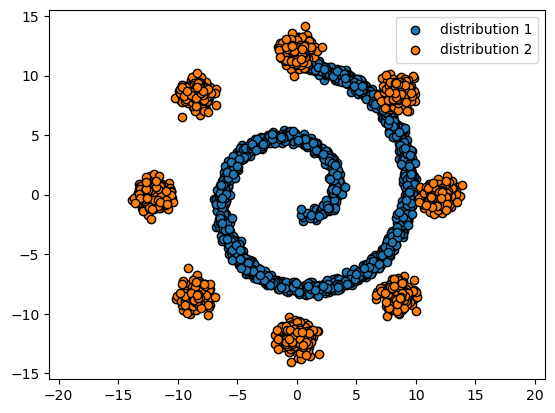

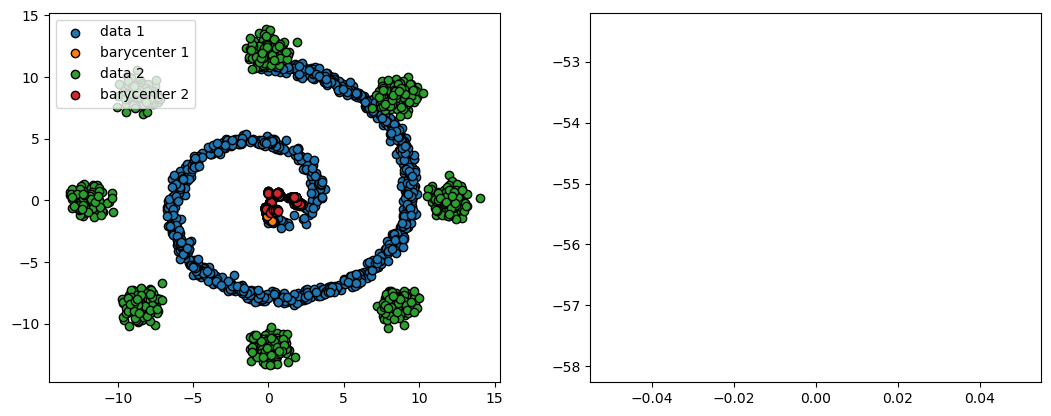

  0%|          | 44/10000 [00:07<29:54,  5.55it/s] 


KeyboardInterrupt: 

In [4]:
import ot

def minibatch_uot(data, Tau, device):
    data = [data[k].detach().cpu() for k in range(CONFIG.K)]
    M = (data[0][:, None, :] - data[1][None, :, :]).pow(2).sum(2).mul(0.5)

    uniform1 = torch.ones(len(data[0])) / len(data[0])
    uniform2 = torch.ones(len(data[1])) / len(data[1])

    reg_m = (100, Tau)

    kl_uot = ot.unbalanced.mm_unbalanced(uniform1, uniform2, M, reg_m, div='kl')

    idx = kl_uot.argmax(1)
    BARYCENTERS = {}
    data[1] = data[1][idx] # replace data
    return [data[k].to(device) for k in range(CONFIG.K)]

def train(
    maps: OTMap, maps_opt, maps_sched, 
    pots: Pots, pots_opt, pots_sched,
    reg_coeff: float = 0.0, tau: float = 1.0,
):
    ## We assume that divergence1 = 'balanced' and divergence2 = 'kl'
    losses = []
    for epoch in tqdm(range(CONFIG.NUM_EPOCHS)):        
        freeze(pots)
        unfreeze(maps)
        
        #inner loop
        for it in range(CONFIG.INNER_ITERATIONS):
            for n in range(1):
                # data sampling
                data = [datas[k].sample([CONFIG.BATCH_SIZE]).to(CONFIG.DEVICE) for k in range(CONFIG.K)]
                # revise data by minibatch sampling
                data = minibatch_uot(data, Tau, CONFIG.DEVICE)

                maps_opt.zero_grad()
                loss = 0
                for k in range(CONFIG.K):
                    mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
                    cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
                    cost -= pots[k](mapped_x_k)  # [B, 1]
                    cost += reg_coeff * torch.unsqueeze(reg, -1)
                    cost = cost.mean(dim=0)
                    loss += CONFIG.LAMBDAS[k] * cost
                loss.backward()
                maps_opt.step()
                maps_sched.step()

        # unfreezing potentials 
        # freezing maps
        unfreeze(pots)
        freeze(maps)
        
        # outer optimiztion
        pots_opt.zero_grad()
        loss=0

        cost = None
        for k in range(CONFIG.K):
            mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
            
            cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
            
            cost -= pots[k](mapped_x_k)  # [B, 1]
            cost += reg_coeff * torch.unsqueeze(reg, -1)
            cost = cost.mean(dim=0)
            loss += CONFIG.LAMBDAS[k] * cost
        
        loss = -1*loss
        losses.append(loss.item())
        loss.backward()
        pots_opt.step()
        pots_sched.step()
        
        
        # plotting part
        if epoch % 200 ==0 :
            data = [datas[k].sample([1_000]).to(CONFIG.DEVICE)
                        for k in range(CONFIG.K)]
            
            clear_output(wait=True)
            fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))
            for k in range(CONFIG.K):
                d = maps[k](data[k]).detach().cpu()
                ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(),edgecolor='black',label=f'data {k+1}')
                ax.scatter(d[:,0],d[:,1],edgecolor='black',label=f'barycenter {k+1}')
                ax.grid()
                ax.legend()
                # ax.set_xlim(-8, 8)
                # ax.set_ylim(-8, 8)
                
            ax_l.plot(losses)
            plt.show()

seed_everything(0, avoid_benchmark_noise=True)

maps_ur = nn.ModuleList([
    DeterministicMap(CONFIG.INPUT_DIM, CONFIG.HIDDEN_DIMS, CONFIG.OUTPUT_DIM_MAP)
    for _ in range(CONFIG.K)
]).to(CONFIG.DEVICE)
maps_opt, maps_sched = get_opt_sched(maps_ur, CONFIG.LR, CONFIG.NUM_EPOCHS * CONFIG.INNER_ITERATIONS)

pots_ur = get_pots(CONFIG)
pots_opt, pots_sched = get_opt_sched(pots_ur, CONFIG.LR, CONFIG.NUM_EPOCHS)

train(maps_ur, maps_opt, maps_sched, 
      pots_ur, pots_opt, pots_sched, 
      tau=Tau)

Visualize

In [ ]:
divergences = [divergence1, divergence2]
data = [datas[k].sample([1000]).to(CONFIG.DEVICE) for k in range(CONFIG.K)]

TRAINED_BARYCENTERS = {}

clear_output(wait=True)
fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))
for k in range(CONFIG.K):
    U = torch.rand(len(data[k]))
    mapped_x_k, _ = maps_ur[k](data[k], reg=True)  # [B, N]
    f_c = strong_cost(data[k], mapped_x_k)  # [B, 1]
    f_c -= pots_ur[k](mapped_x_k)
    
    c = torch.max(torch.exp(-f_c/Tau)).cpu()


    acc = data[k]
    
    mapped_x_k_acc, _ = maps_ur[k](acc, reg=True)
    
    TRAINED_BARYCENTERS[f'mu_{k}'] = acc.detach().cpu().numpy()
    TRAINED_BARYCENTERS[f'barycenter_{k}'] = mapped_x_k_acc.detach().cpu().numpy()

    ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(), edgecolor='black',label=f'data {k+1}')
    ax.scatter(acc[:,0].cpu(),acc[:,1].cpu(),color='black',edgecolor='black',label=f'accepted {k+1}')
    # if k==0:
    lines =  list(zip(acc[:64].cpu().detach().numpy(), mapped_x_k_acc[:64].cpu().detach().numpy()))
    lc = mc.LineCollection(lines, linewidths=0.5, color='white', zorder=4)
    ax.scatter(mapped_x_k_acc[:,0].cpu().detach(), mapped_x_k_acc[:,1].cpu().detach(), edgecolor='black',label=f'barycenter {k+1}')
    ax.add_collection(lc)
    ax.grid()
    ax.legend()
    # ax.set_xlim(-8, 8)
    # ax.set_ylim(-8, 8)

plt.show()

Evaluation

In [ ]:
import ot
data = [data[k].detach().cpu() for k in range(CONFIG.K)]
M = (data[0][:, None, :] - data[1][None, :, :]).pow(2).sum(2).mul(0.5)

uniform1 = torch.ones(len(data[0])) / len(data[0])
uniform2 = torch.ones(len(data[1])) / len(data[1])

reg_m = (100, Tau)

kl_uot = ot.unbalanced.mm_unbalanced(uniform1, uniform2, M, reg_m, div='kl')

In [ ]:
idx = kl_uot.argmax(1)
BARYCENTERS = {}
BARYCENTERS['mu_0'] = data[0].detach().cpu().numpy()
BARYCENTERS['mu_1'] = data[1][idx].detach().cpu().numpy()
BARYCENTERS['barycenter'] = (CONFIG.LAMBDAS[0] * BARYCENTERS['mu_0'] + CONFIG.LAMBDAS[1] * BARYCENTERS['mu_1']) / sum(CONFIG.LAMBDAS)

In [ ]:
# Measurement 1: Accepted Samples for source and target (W2)
for k in range(2):
    fake, real = TRAINED_BARYCENTERS[f'mu_{k}'], BARYCENTERS[f'mu_{k}']
    u1, u2 = np.ones(len(fake)) / len(fake), np.ones(len(real)) / len(real)
    M = 0.5 * np.sum((fake[:,np.newaxis,:] - real[np.newaxis,:,:])**2, axis=2)
    print(f'W2 distance between Accepted mu_{k}: {ot.emd2(u1, u2, M)}')


# Measurement 2: Integral L2 of real and learned transport maps w.r.t. Accepted samples from real
with torch.no_grad():
    for k in range(2):
        source = torch.tensor(BARYCENTERS[f'mu_{k}']).float().to(CONFIG.DEVICE)
        barycenter = maps_ur[k](source).detach().cpu().numpy()
        print(f'L2 dist of T_{k} and T_{k}_real:', ((BARYCENTERS['barycenter'] - barycenter)**2).sum(1).mean())


# Measurement 3: Distance between barycenters
for k in range(2):
    fake, real = TRAINED_BARYCENTERS[f'barycenter_{k}'], BARYCENTERS['barycenter']
    u1, u2 = np.ones(len(fake)) / len(fake), np.ones(len(real)) / len(real)
    M = 0.5 * np.sum((fake[:,np.newaxis,:] - real[np.newaxis,:,:])**2, axis=2)
    print(f'W2 distance between Barycenters {k}: {ot.emd2(u1, u2, M)}')

Save

In [ ]:
# save transport maps
parent = f'ckpts/COMPARISONS_{data_name1}_{data_name2}_Tau{Tau}'
EXP_DIR = os.path.join(parent, f'batchUOT-OTbary')
os.makedirs(EXP_DIR, exist_ok=True)

for k, map in enumerate(maps_ur):
    torch.save(map.state_dict(), os.path.join(EXP_DIR, f'net{k}_epoch_{CONFIG.NUM_EPOCHS}.pth'))